The reddit dataset from the HF Datasets repo is HUGE (20+ GiB) and I did not want that cached on my local machine so the first few steps were processed in a Colab notebook. Below are the steps I took in that notebook to create a subset of reddit posts from a select assortment of some of the most populated subreddits. 

The full dataset has over 3.8 million posts in thousands of subreddits. I first identify the most popular subreddits by number of posts. I then select the top 10 subreddits and a curated list of subreddits (those that I believe have more meaningful subreddit names) and select out only those posts which are associated with this list of subreddits. 

The top 3 subreddits (AskReddit, relationships, leagueoflegends) have an order of magnitude more posts than any other subreddit. To keep the subset manageable, I only include the first 60K posts from these subreddits. 

The result is a subset of 636695 reddit posts from 16 popular subreddits. Saved as a df, this file is a "mere" 2.7 GiB. 

```python

from datasets import load_dataset
dataset = load_dataset("reddit")

"""
Downloading:
4.38k/? [00:01<00:00, 3.32kB/s]

Downloading:
2.83k/? [00:00<00:00, 3.28kB/s]
Using custom data configuration default

Downloading and preparing dataset reddit/default (download: 2.93 GiB, generated: 17.64 GiB, post-processed: Unknown size, total: 20.57 GiB) to /root/.cache/huggingface/datasets/reddit/default/1.0.0/98ba5abea674d3178f7588aa6518a5510dc0c6fa8176d9653a3546d5afcb3969...
Downloading: 100%
3.14G/3.14G [05:26<00:00, 9.62MB/s]

3848330/0 [06:29<00:00, 10409.42 examples/s]
Dataset reddit downloaded and prepared to /root/.cache/huggingface/datasets/reddit/default/1.0.0/98ba5abea674d3178f7588aa6518a5510dc0c6fa8176d9653a3546d5afcb3969. Subsequent calls will reuse this data.
"""

dataset = dataset['train']

unique_subreddits, counts = np.unique(dataset['subreddit'], return_counts=True)

top_subreddits = [sr for c, sr in sorted(zip(counts, unique_subreddits), reverse=True)]

top_subreddits[:30]
#['AskReddit', 'relationships', 'leagueoflegends', 'tifu', 'relationship_advice', 'trees', 'gaming', 'atheism', 'AdviceAnimals', 'funny', 'politics', 'pics', 'sex', 'WTF', 'explainlikeimfive', 'todayilearned', 'Fitness', 'IAmA', 'worldnews', 'DotA2', 'TwoXChromosomes', 'videos', 'DestinyTheGame', 'reddit.com', 'offmychest', 'buildapc', 'AskMen', 'personalfinance', 'summonerschool', 'technology']


top10_subreddits = top_subreddits[:10]
curated_subreddits = ['relationships', 'trees', 'gaming', 'funny', 'politics', 'sex', 'Fitness', 'worldnews', 'personalfinance', 'technology']

relevant_subreddits = list(set(top10_subreddits).union(set(curated_subreddits)))
subreddit_mask = np.zeros(len(dataset))

# The top 3 categories each contain between 100k and 600k posts -- an order of magnitude more 
# than any other popular subreddit. I artificially truncate these 3 categories to 60K posts each
askreddit = 0
relationships = 0
lol = 0
max_examples = 60000

for i, sub in enumerate(dataset['subreddit']):
  if sub in relevant_subreddits:
    if sub == 'AskReddit' and askreddit <= max_examples:
      subreddit_mask[i] = 1
      askreddit += 1
    elif sub == 'relationships' and relationships <= max_examples:
      subreddit_mask[i] = 1
      relationships += 1
    elif sub == 'leagueoflegends' and lol <= max_examples:
      subreddit_mask[i] = 1
      lol += 1
    elif sub not in ['AskReddit', 'relationships', 'leagueoflegends']:    
      subreddit_mask[i] = 1
    else:
      continue

subreddit_mask = subreddit_mask == 1

np.sum(subreddit_mask)
#636695 (reduced from over 3.8M!)

subset = dataset[subreddit_mask]

subset = pd.DataFrame(subset)
subset.to_csv("reddit_subset.pd")
```

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

filename = "../data/reddit/reddit_subset.csv"

In [2]:
df = pd.read_csv(filename)

In [3]:
df.head()

,author,body,content,id,normalizedBody,subreddit,subreddit_id,summary
0,Stork13,Art is about the hardest thing to categorize i...,Art is about the hardest thing to categorize i...,c6a9nxd,Art is about the hardest thing to categorize i...,funny,t5_2qh33,Personal opinions 'n shit.
1,splagaticusxoxo97,FALSE. Evidence: Wolfman is a man with hair al...,FALSE. Evidence: Wolfman is a man with hair al...,c6bacqq,FALSE. Evidence: Wolfman is a man with hair al...,atheism,t5_2qh2p,dont fuck with red timber wolves
2,phyzishy,"Yeah, but most folks think avoiding gluten wil...","Yeah, but most folks think avoiding gluten wil...",c6b52m8,"Yeah, but most folks think avoiding gluten wil...",AskReddit,t5_2qh1i,stupid stuff.
3,Wheelman,As an entrepreneur/freelancer (especially a su...,As an entrepreneur/freelancer (especially a su...,c6b34c2,As an entrepreneur/freelancer (especially a su...,personalfinance,t5_2qstm,get a good CPA - they aren't that expensive bu...
4,Perservere,Didn't they lose 6 games in a row? Just becaus...,Didn't they lose 6 games in a row? Just becaus...,c6bftvc,Didn't they lose 6 games in a row? Just becaus...,leagueoflegends,t5_2rfxx,"just because you're close ""at times"" doesn't m..."


In [24]:
df['category'] = df['subreddit'].map({
    'atheism': 'atheism',
    'funny': 'funny',
    'sex': 'sex',
    'Fitness': 'fitness',
    'AdviceAnimals': 'advice animals',
    'trees': 'trees',
    'personalfinance': 'personal finance', 
    'relationships': 'relationships',
    'relationship_advice': 'relationship advice',
    'tifu': 'tifu',
    'politics': 'politics',
    'gaming': 'gaming', 
    'worldnews': 'world news',
    'technology': 'technology',
    'leagueoflegends': 'league of legends',
    'AskReddit': 'ask reddit'
    })

df['category'] = pd.Categorical(df.category)
df['label'] = df.category.cat.codes

In [52]:
df.dropna(inplace=True)
df.head()

,author,body,content,id,normalizedBody,subreddit,subreddit_id,summary,category,label
0,Stork13,Art is about the hardest thing to categorize i...,Art is about the hardest thing to categorize i...,c6a9nxd,Art is about the hardest thing to categorize i...,funny,t5_2qh33,Personal opinions 'n shit.,funny,4
1,splagaticusxoxo97,FALSE. Evidence: Wolfman is a man with hair al...,FALSE. Evidence: Wolfman is a man with hair al...,c6bacqq,FALSE. Evidence: Wolfman is a man with hair al...,atheism,t5_2qh2p,dont fuck with red timber wolves,atheism,2
2,phyzishy,"Yeah, but most folks think avoiding gluten wil...","Yeah, but most folks think avoiding gluten wil...",c6b52m8,"Yeah, but most folks think avoiding gluten wil...",AskReddit,t5_2qh1i,stupid stuff.,ask reddit,1
3,Wheelman,As an entrepreneur/freelancer (especially a su...,As an entrepreneur/freelancer (especially a su...,c6b34c2,As an entrepreneur/freelancer (especially a su...,personalfinance,t5_2qstm,get a good CPA - they aren't that expensive bu...,personal finance,7
4,Perservere,Didn't they lose 6 games in a row? Just becaus...,Didn't they lose 6 games in a row? Just becaus...,c6bftvc,Didn't they lose 6 games in a row? Just becaus...,leagueoflegends,t5_2rfxx,"just because you're close ""at times"" doesn't m...",league of legends,6


In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, df['subreddit'], test_size=.1, random_state=42, stratify=df['subreddit'])

In [56]:
np.unique(X_train.subreddit, return_counts=True)

(array(['AdviceAnimals', 'AskReddit', 'Fitness', 'atheism', 'funny',
        'gaming', 'leagueoflegends', 'personalfinance', 'politics',
        'relationship_advice', 'relationships', 'sex', 'technology',
        'tifu', 'trees', 'worldnews'], dtype=object),
 array([36692, 53990, 20423, 38939, 36141, 39459, 53994, 12963, 32865,
        45374, 53999, 25924, 12328, 46994, 42551, 20319]))

In [57]:
np.unique(X_test.subreddit, return_counts=True)

(array(['AdviceAnimals', 'AskReddit', 'Fitness', 'atheism', 'funny',
        'gaming', 'leagueoflegends', 'personalfinance', 'politics',
        'relationship_advice', 'relationships', 'sex', 'technology',
        'tifu', 'trees', 'worldnews'], dtype=object),
 array([4077, 5999, 2269, 4327, 4016, 4384, 5999, 1440, 3652, 5042, 6000,
        2880, 1370, 5221, 4728, 2258]))

In [58]:
y_train

161007    leagueoflegends
261003            Fitness
504573              trees
351170               tifu
116890            atheism
               ...       
286297               tifu
52903       relationships
75107           AskReddit
365480              funny
70829           AskReddit
Name: subreddit, Length: 572955, dtype: object

In [59]:
y_test

44812           AskReddit
443043      relationships
165384             gaming
96449           AskReddit
510436              trees
               ...       
241516            atheism
308008    leagueoflegends
167308          worldnews
624891              trees
485559      relationships
Name: subreddit, Length: 63662, dtype: object

In [61]:
X_train.to_csv("../data/reddit/reddit_subset_train.csv")
X_test.to_csv("../data/reddit/reddit_subset_test.csv")

In [66]:
X_train["subreddit"].value_counts()[:10]

relationships          53999
leagueoflegends        53994
AskReddit              53990
tifu                   46994
relationship_advice    45374
trees                  42551
gaming                 39459
atheism                38939
AdviceAnimals          36692
funny                  36141
Name: subreddit, dtype: int64

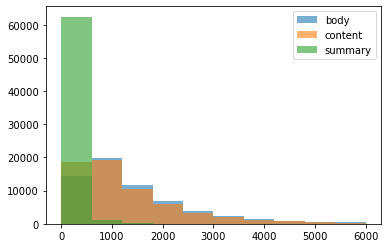

In [67]:
import matplotlib.pyplot as plt
import numpy as np

def count_characters(x):
    return len(x)

plt.hist(X_test.body.apply(count_characters).values, alpha=.6, range=(0,6000), label='body');
plt.hist(X_test.content.apply(count_characters).values, alpha=.6, range=(0,6000), label='content');
plt.hist(X_test.summary.apply(count_characters).values, alpha=.6, range=(0,6000), label='summary');
plt.legend()

summary_lengths = X_test.summary.apply(count_characters).values

In [68]:
print(np.mean(summary_lengths))
print(np.median(summary_lengths))
print(np.max(summary_lengths))

136.17712293047657
96.0
4698


# Most frequent words in reddit dataset

In [21]:
import string
from collections import Counter
from nltk import FreqDist, word_tokenize

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/mbeck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mbeck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
df.dropna(inplace=True)

In [13]:
corpus = ''

for summary in df.summary:
    try:
        corpus += summary
    except:
        print(summary)

In [15]:
thing = word_tokenize(corpus)

In [24]:
len(thing)

17603154

In [33]:
stop1 = list(string.punctuation) + ["``", "''", "..."] #
stop2 = stopwords.words("english") + list(string.punctuation) + ["``", "''", "..."]
words1 = [word for word in thing if word not in stop1]
words2 = [word for word in thing if word not in stop2]

In [34]:
print(len(words1))
print(len(words2))

15900692
9046851


In [38]:
word_freq1 = Counter(words1).most_common(100000)
most_common_words1, counts = [list(c) for c in zip(*word_freq1)]

word_freq2 = Counter(words2).most_common(100000)
most_common_words2, counts = [list(c) for c in zip(*word_freq2)]

In [44]:
most_common_words = {"no_punc": most_common_words1, "no_punc_no_stop": most_common_words2}

In [46]:
import pickle

pickle.dump(most_common_words, open("../data/reddit/most_common_words.pkl", "wb"))

--> SHOULD create new w2v vectors over the reddit corpus!!

## Subsample the train corpus because it's too big

In [2]:
df_train = pd.read_csv("../data/reddit/reddit_subset_train.csv")

In [15]:
df_train.head()

,Unnamed: 0,author,body,content,id,normalizedBody,subreddit,subreddit_id,summary,category,label
0,161007,SkettiOnToast,Can I make a suggestion for the tribunal? (bec...,Can I make a suggestion for the tribunal? (bec...,c7xbafm,Can I make a suggestion for the tribunal? (bec...,leagueoflegends,t5_2rfxx,"Just some sugestions, the first of giving you ...",league of legends,6
1,261003,llSinniSll,"First, it doesn't matter if you are fat or ski...","First, it doesn't matter if you are fat or ski...",cdru1md,"First, it doesn't matter if you are fat or ski...",Fitness,t5_2qhx4,"In short, supplements are great tools when use...",fitness,3
2,504573,[deleted],I've recently bought an Aerospaced 4 pc grinde...,I've recently bought an Aerospaced 4 pc grinde...,t3_17zrdh,I've recently bought an Aerospaced 4 pc grinde...,trees,t5_2r9vp,New grinder is not up to par. Should I shell o...,trees,14
3,351170,thickranchdressing,It was the last evening of a business trip. M...,It was the last evening of a business trip. M...,c79fw9z,It was the last evening of a business trip. M...,tifu,t5_2to41,fucked my coworker at the end of a business tr...,tifu,13
4,116890,mtn_dewgamefuel,There are census records and roman writing tha...,There are census records and roman writing tha...,c3p6moa,There are census records and roman writing tha...,atheism,t5_2qh2p,Jesus existed but was a massive troll and noth...,atheism,2


In [4]:
curated_subreddits = ['relationships', 'trees', 'gaming', 'funny', 'politics', \
        'sex', 'Fitness', 'worldnews', 'personalfinance', 'technology']

In [33]:
sample = (
    df_train[df_train.subreddit.isin(curated_subreddits)]
    .groupby('category', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), 2000), random_state=42))
)

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(sample, sample['subreddit'], 
                                                      test_size=.5, 
                                                      random_state=42, 
                                                      stratify=sample['subreddit'])

In [45]:
len(X_train), len(X_valid)

(10000, 10000)

In [46]:
X_train.to_csv("../data/reddit/reddit_subset_train1000.csv")
X_valid.to_csv("../data/reddit/reddit_subset_valid1000.csv")

## Create a subset of the reddit test set that has exactly 1300 examples per category
This makes error analysis easier

In [1]:
df_test = pd.read_csv("../data/reddit_subset_test.csv")

# In our experiments we'll work with just 10 of the 16 most popular subreddits
curated_subreddits = ['relationships', 'trees', 'gaming', 'funny', 'politics', \
      'sex', 'Fitness', 'worldnews', 'personalfinance', 'technology']

df_reddit_test = (
  df_test[df_test.subreddit.isin(curated_subreddits)]
  .groupby('category', group_keys=False)
  .apply(lambda x: x.sample(min(len(x), 1300), random_state=42))
  .assign(
      category = lambda df: pd.Categorical(df.category),
      label = lambda df: df.category.cat.codes
      )
  )
reddit_test_data = create_dataset_from_df(df_reddit_test, 'summary')
torch_save("../data/reddit_dataset_1300.pt")

NameError: name 'pd' is not defined

***If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices.  A copy of the Apache License Version 2.0 can be found [here](https://opensource.org/licenses/Apache-2.0).***